In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import re
from tqdm import tqdm
import tifffile as tif
import cv2
from read_roi import read_roi_zip as co_zip
import ants
from scipy import ndimage, spatial
import utils.analysis as analysis
import pandas as pd

/home/tli_project/.local/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# set your variables
neuron_path = '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211011_P37_N1/211011_P37_N1_FlipV_R290_clahe.tif'
mask_path = '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211011_P37_N1/211011_P37_N1_FlipV_R290_mask.tif'
Roi_path = '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211011_P37_N1/211011_P37_N1_FlipV_R290_ColRois2.zip'

In [3]:
# load data
cols = co_zip(Roi_path)
neuron = tif.imread(neuron_path)
mask = tif.imread(mask_path)

In [4]:
neuron -= neuron.min()
neuron[mask == 0] = 0
neuron[neuron > 0] = 1

In [5]:
lifetimes = analysis.cal_lifetimes(neuron, save=False)
neuron = lifetimes.copy()
neuron[neuron<5] = 0
# stable_neuron = analysis.stable_N(lifetimes, stab_limit=5, save=False) 

100%|██████████| 84/84 [00:02<00:00, 37.95it/s]


In [11]:
# delete unused images to reduce memory usage
del lifetimes
del mask

In [6]:
# Sometimes you might want or need to remove some columns
# cols_include = ['0,0', '0,1', '0,-1', '-1,-2', '1,0', '1,1', '-1,-1', '-1,0', '-2,-2', '-2,-1', '-2,-3', '0,-2', '1,-1']
# cols = {col:val for col,val in cols.items() if col in cols_include}
cols.keys()

odict_keys(['0,0', '0,1', '0,-1', '-1,-3', '-1,-2', '1,0', '2,1', '1,1', '-1,-1', '-1,0', '-2,-2', '-2,-1', '-2,-3', '0,-2', '1,-1'])

In [9]:
cols['0,0']

{'type': 'oval',
 'left': 179,
 'top': 124,
 'width': 53,
 'height': 68,
 'name': '0,0',
 'position': {'channel': 0, 'slice': 26, 'frame': 63}}

In [7]:
# get columns centroids (only three are needed but the code is simpler this way)
cols_centroids = {}
for col, val in cols.items():
    if val['type'] == 'oval':
            x0 = val['left']+int(val['width']/2); a = int(val['width']/2)  # x center, half width                                       
            y0 = val['top']+int(val['height']/2); b = int(val['height']/2)  # y center, half height  
            cols_centroids[col] = (y0,x0,a,b) 

In [8]:
cols_centroids['0,0']

(158, 205, 26, 34)

In [8]:
cols_centroids_arr = np.array([(i[0],i[1]) for i in cols_centroids.values()])
cols_names = list(cols_centroids.keys())

In [9]:
# get the mask of each col based on distances from centroids 
neu_PC = np.argwhere(np.ones_like(neuron[0,0]))
cols_masks = {col:np.zeros_like(neuron[0,0]) for col in cols_centroids.keys()}
for px in tqdm(neu_PC):
    dist, ind = spatial.KDTree(cols_centroids_arr).query(px)
    col = cols_names[ind]
    cols_masks[col][px[0],px[1]]=1

100%|██████████| 160000/160000 [00:05<00:00, 29292.67it/s]


In [10]:
# assigning each pixel of the neuron lifetimes to the right column based on the masks created above
cols_occupancies = {col:np.zeros_like(neuron) for col in cols_centroids.keys()}
for col, val in cols_occupancies.items():
    Roi_3D = np.broadcast_to(cols_masks[col], neuron.shape)
    cols_occupancies[col] = Roi_3D * neuron 

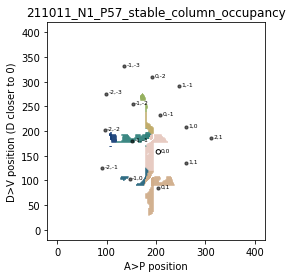

In [123]:
# plotting the neuron color-coded based on column's ID
cols_names = list(cols_centroids.keys()) # here it's possible to change the order of the columns or remove some from the plot
cols_multi = {col:i+1 for i, col in enumerate(cols_names)}

# setting the color_map
vmin, vmax= 0,len(cols_names)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
p = plt.get_cmap('gist_earth_r')

plot_im = np.zeros_like(neuron[0,0])
for col in cols_names:
    subset = cols_occupancies[col][-1].max(axis=0)
    subset[subset>0] = cols_multi[col]
    plot_im += subset

# plt.imshow(plot_im,cmap='gist_earth_r')
# # for col, val in :
# #     ax.annotate(labels1[i], (xs_1[i]+0.5, ys_1[i]))
# plt.scatter(cols_centroids_arr[1:,1],cols_centroids_arr[1:,0],s=20,c='k')
# for ind, col in enumerate(cols_names):
#     plt.annotate(col,(cols_centroids_arr[ind,1]+0.2,cols_centroids_arr[ind,0]))
# plt.scatter(cols_centroids_arr[0,1],cols_centroids_arr[0,0],s=40,edgecolors='k',facecolors='none')
# plt.title('211011_N1_P57_stable_column_occupancy')
# plt.xlabel('A>P position')
# plt.ylabel('D>V position (D closer to 0)')
# plt.gca().set_aspect('equal')
# plt.savefig('211011_N1_P57_stable_column_occupancy_11.pdf')

plot_PC = np.argwhere(plot_im)
neu_values = plot_im[plot_im>0]
plot_PC = np.insert(plot_PC,2,neu_values,axis=1)
plt.scatter(plot_PC[:,1],plot_PC[:,0],color=p(plot_PC[:,2]*20),s=0.01,alpha=1, marker=',')

# plotting the centroids' position
plt.scatter(cols_centroids_arr[1:,1],cols_centroids_arr[1:,0],s=10,c='k', alpha=0.6)
plt.scatter(cols_centroids_arr[0,1],cols_centroids_arr[0,0],s=20,edgecolors='k',facecolors='none')
for ind, col in enumerate(cols_names):
    plt.annotate(col,(cols_centroids_arr[ind,1]+5,cols_centroids_arr[ind,0]+0.2), fontsize=6)

plt.title('211011_N1_P57_stable_column_occupancy')
plt.xlabel('A>P position')
plt.ylabel('D>V position (D closer to 0)')
# to set the axis equal
plt.plot([0,400], [0,400],c='none')
plt.gca().set_aspect('equal')

plt.savefig('211011_N1_P57_stable_column_occupancy_13.pdf')

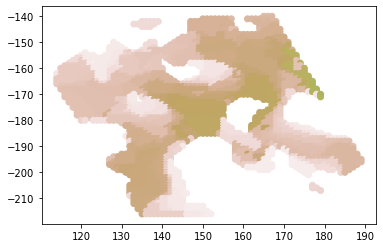

In [119]:
# plotting the lifetimes of pixels at the last timepoint within a column (e.g: 0,1)

subset = cols_occupancies['-1,-1'][-1]
result = np.zeros_like(subset[0])
for y, line in enumerate(result):
    for x, val in enumerate(line):
        # x = int(x)
        z_val = subset[:,y,x]
        result[y,x] = z_val.max()
        # result[y,x] = np.median(z_val[z_val>0])
plot_PC = np.argwhere(result>0)
neu_values = result[result>0]
plot_PC = np.insert(plot_PC,2,neu_values,axis=1)
plt.scatter(plot_PC[:,1],-1*plot_PC[:,0],color=p(plot_PC[:,2]))
# plt.imshow(result)


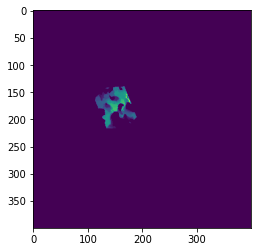

In [117]:
plt.imshow(subset.max(axis=0))

In [118]:
subset.max()

85.0